# Convolutional Layer Implementation from Scratch

## 1. Introduction

Convolutional Neural Networks (CNNs) have revolutionized computer vision and signal processing. At their core lies the **convolutional layer**, which applies learned filters to extract hierarchical features from input data. This notebook provides a rigorous mathematical foundation and a complete implementation of a 2D convolutional layer.

## 2. Mathematical Foundation

### 2.1 Discrete Convolution

The discrete 2D convolution operation between an input signal $\mathbf{X}$ and a kernel $\mathbf{K}$ is defined as:

$$
(\mathbf{X} * \mathbf{K})[i, j] = \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} \mathbf{X}[i+m, j+n] \cdot \mathbf{K}[m, n]
$$

where $M \times N$ is the kernel size.

### 2.2 Cross-Correlation in Deep Learning

In practice, deep learning frameworks implement **cross-correlation** rather than true convolution (which would flip the kernel). The operation is:

$$
\mathbf{Y}[i, j] = \sum_{m=0}^{K_h-1} \sum_{n=0}^{K_w-1} \mathbf{X}[i \cdot s + m, j \cdot s + n] \cdot \mathbf{W}[m, n] + b
$$

where:
- $\mathbf{X} \in \mathbb{R}^{H \times W}$ is the input feature map
- $\mathbf{W} \in \mathbb{R}^{K_h \times K_w}$ is the learnable kernel (weights)
- $b \in \mathbb{R}$ is the bias term
- $s$ is the stride
- $\mathbf{Y} \in \mathbb{R}^{H' \times W'}$ is the output feature map

### 2.3 Output Dimensions

For an input of size $H \times W$, kernel size $K_h \times K_w$, stride $s$, and padding $p$, the output dimensions are:

$$
H' = \left\lfloor \frac{H + 2p - K_h}{s} \right\rfloor + 1
$$

$$
W' = \left\lfloor \frac{W + 2p - K_w}{s} \right\rfloor + 1
$$

### 2.4 Multi-Channel Convolution

For inputs with $C_{in}$ channels and $C_{out}$ output filters:

$$
\mathbf{Y}[c_{out}, i, j] = \sum_{c_{in}=0}^{C_{in}-1} \sum_{m=0}^{K_h-1} \sum_{n=0}^{K_w-1} \mathbf{X}[c_{in}, i \cdot s + m, j \cdot s + n] \cdot \mathbf{W}[c_{out}, c_{in}, m, n] + b[c_{out}]
$$

The weight tensor has shape $\mathbf{W} \in \mathbb{R}^{C_{out} \times C_{in} \times K_h \times K_w}$.

### 2.5 Backpropagation Through Convolution

Given the loss gradient $\frac{\partial \mathcal{L}}{\partial \mathbf{Y}}$, the gradients are:

**Gradient w.r.t. weights:**
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}[m, n]} = \sum_{i} \sum_{j} \frac{\partial \mathcal{L}}{\partial \mathbf{Y}[i, j]} \cdot \mathbf{X}[i \cdot s + m, j \cdot s + n]
$$

**Gradient w.r.t. input:**
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{X}[i', j']} = \sum_{i} \sum_{j} \sum_{m} \sum_{n} \frac{\partial \mathcal{L}}{\partial \mathbf{Y}[i, j]} \cdot \mathbf{W}[m, n] \cdot \delta_{i'+m, i \cdot s} \cdot \delta_{j'+n, j \cdot s}
$$

This is equivalent to a **full convolution** of the output gradient with the flipped kernel.

## 3. Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

np.random.seed(42)

### 3.1 Convolutional Layer Class

In [2]:
class Conv2D:
    """
    2D Convolutional Layer implementation from scratch.
    
    Parameters:
    -----------
    in_channels : int
        Number of input channels
    out_channels : int
        Number of output channels (filters)
    kernel_size : int or tuple
        Size of the convolutional kernel
    stride : int
        Stride of the convolution
    padding : int
        Zero-padding added to both sides of the input
    """
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        
        # Xavier/Glorot initialization
        fan_in = in_channels * self.kernel_size[0] * self.kernel_size[1]
        fan_out = out_channels * self.kernel_size[0] * self.kernel_size[1]
        std = np.sqrt(2.0 / (fan_in + fan_out))
        
        # Weights: (out_channels, in_channels, kernel_h, kernel_w)
        self.weights = np.random.randn(
            out_channels, in_channels, self.kernel_size[0], self.kernel_size[1]
        ) * std
        
        # Bias: (out_channels,)
        self.bias = np.zeros(out_channels)
        
        # Cache for backpropagation
        self.cache = None
        
        # Gradients
        self.grad_weights = None
        self.grad_bias = None
    
    def _pad_input(self, x):
        """Apply zero-padding to input."""
        if self.padding == 0:
            return x
        return np.pad(
            x,
            ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)),
            mode='constant',
            constant_values=0
        )
    
    def forward(self, x):
        """
        Forward pass of convolution.
        
        Parameters:
        -----------
        x : ndarray of shape (batch_size, in_channels, height, width)
        
        Returns:
        --------
        out : ndarray of shape (batch_size, out_channels, out_height, out_width)
        """
        batch_size, _, h, w = x.shape
        kh, kw = self.kernel_size
        
        # Apply padding
        x_padded = self._pad_input(x)
        
        # Calculate output dimensions
        h_padded, w_padded = x_padded.shape[2], x_padded.shape[3]
        out_h = (h_padded - kh) // self.stride + 1
        out_w = (w_padded - kw) // self.stride + 1
        
        # Initialize output
        out = np.zeros((batch_size, self.out_channels, out_h, out_w))
        
        # Perform convolution
        for i in range(out_h):
            for j in range(out_w):
                h_start = i * self.stride
                h_end = h_start + kh
                w_start = j * self.stride
                w_end = w_start + kw
                
                # Extract receptive field: (batch_size, in_channels, kh, kw)
                receptive_field = x_padded[:, :, h_start:h_end, w_start:w_end]
                
                # Compute output for all filters
                # weights: (out_channels, in_channels, kh, kw)
                # result: (batch_size, out_channels)
                for k in range(self.out_channels):
                    out[:, k, i, j] = np.sum(
                        receptive_field * self.weights[k], axis=(1, 2, 3)
                    ) + self.bias[k]
        
        # Cache for backward pass
        self.cache = (x, x_padded)
        
        return out
    
    def backward(self, grad_output):
        """
        Backward pass of convolution.
        
        Parameters:
        -----------
        grad_output : ndarray of shape (batch_size, out_channels, out_h, out_w)
        
        Returns:
        --------
        grad_input : ndarray of shape (batch_size, in_channels, height, width)
        """
        x, x_padded = self.cache
        batch_size, _, h, w = x.shape
        _, _, out_h, out_w = grad_output.shape
        kh, kw = self.kernel_size
        
        # Initialize gradients
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_bias = np.zeros_like(self.bias)
        grad_x_padded = np.zeros_like(x_padded)
        
        # Compute gradients
        for i in range(out_h):
            for j in range(out_w):
                h_start = i * self.stride
                h_end = h_start + kh
                w_start = j * self.stride
                w_end = w_start + kw
                
                receptive_field = x_padded[:, :, h_start:h_end, w_start:w_end]
                
                for k in range(self.out_channels):
                    # Gradient w.r.t. weights
                    self.grad_weights[k] += np.sum(
                        receptive_field * grad_output[:, k, i, j].reshape(-1, 1, 1, 1),
                        axis=0
                    )
                    
                    # Gradient w.r.t. bias
                    self.grad_bias[k] += np.sum(grad_output[:, k, i, j])
                    
                    # Gradient w.r.t. input
                    grad_x_padded[:, :, h_start:h_end, w_start:w_end] += (
                        self.weights[k] * grad_output[:, k, i, j].reshape(-1, 1, 1, 1)
                    )
        
        # Remove padding from gradient
        if self.padding > 0:
            grad_input = grad_x_padded[:, :, self.padding:-self.padding, self.padding:-self.padding]
        else:
            grad_input = grad_x_padded
        
        return grad_input

### 3.2 Helper Functions

In [3]:
def relu(x):
    """ReLU activation function."""
    return np.maximum(0, x)

def relu_backward(grad_output, x):
    """Backward pass for ReLU."""
    return grad_output * (x > 0)

def mse_loss(y_pred, y_true):
    """Mean Squared Error loss."""
    return np.mean((y_pred - y_true) ** 2)

def mse_loss_backward(y_pred, y_true):
    """Gradient of MSE loss."""
    return 2 * (y_pred - y_true) / y_pred.size

## 4. Demonstration

### 4.1 Edge Detection Example

In [4]:
# Create a synthetic image with edges
def create_test_image(size=32):
    """Create a test image with various edge patterns."""
    img = np.zeros((size, size))
    
    # Vertical edge
    img[:, size//4:size//2] = 1.0
    
    # Horizontal edge
    img[size//4:size//2, :] = np.maximum(img[size//4:size//2, :], 0.5)
    
    # Diagonal pattern
    for i in range(size):
        for j in range(size):
            if (i + j) > size and (i + j) < int(1.5 * size):
                img[i, j] = np.maximum(img[i, j], 0.7)
    
    return img

# Create test image
test_img = create_test_image(32)

# Reshape to (batch_size, channels, height, width)
x = test_img.reshape(1, 1, 32, 32)

print(f"Input shape: {x.shape}")

Input shape: (1, 1, 32, 32)


### 4.2 Apply Convolution with Different Kernels

In [5]:
# Define standard edge detection kernels
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]], dtype=np.float64)

sobel_y = np.array([[-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]], dtype=np.float64)

laplacian = np.array([[0,  1, 0],
                      [1, -4, 1],
                      [0,  1, 0]], dtype=np.float64)

sharpen = np.array([[ 0, -1,  0],
                    [-1,  5, -1],
                    [ 0, -1,  0]], dtype=np.float64)

# Create convolutional layer
conv_layer = Conv2D(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1)

# Set predefined kernels
conv_layer.weights[0, 0] = sobel_x
conv_layer.weights[1, 0] = sobel_y
conv_layer.weights[2, 0] = laplacian
conv_layer.weights[3, 0] = sharpen

# Forward pass
output = conv_layer.forward(x)
print(f"Output shape: {output.shape}")

Output shape: (1, 4, 32, 32)


### 4.3 Visualization

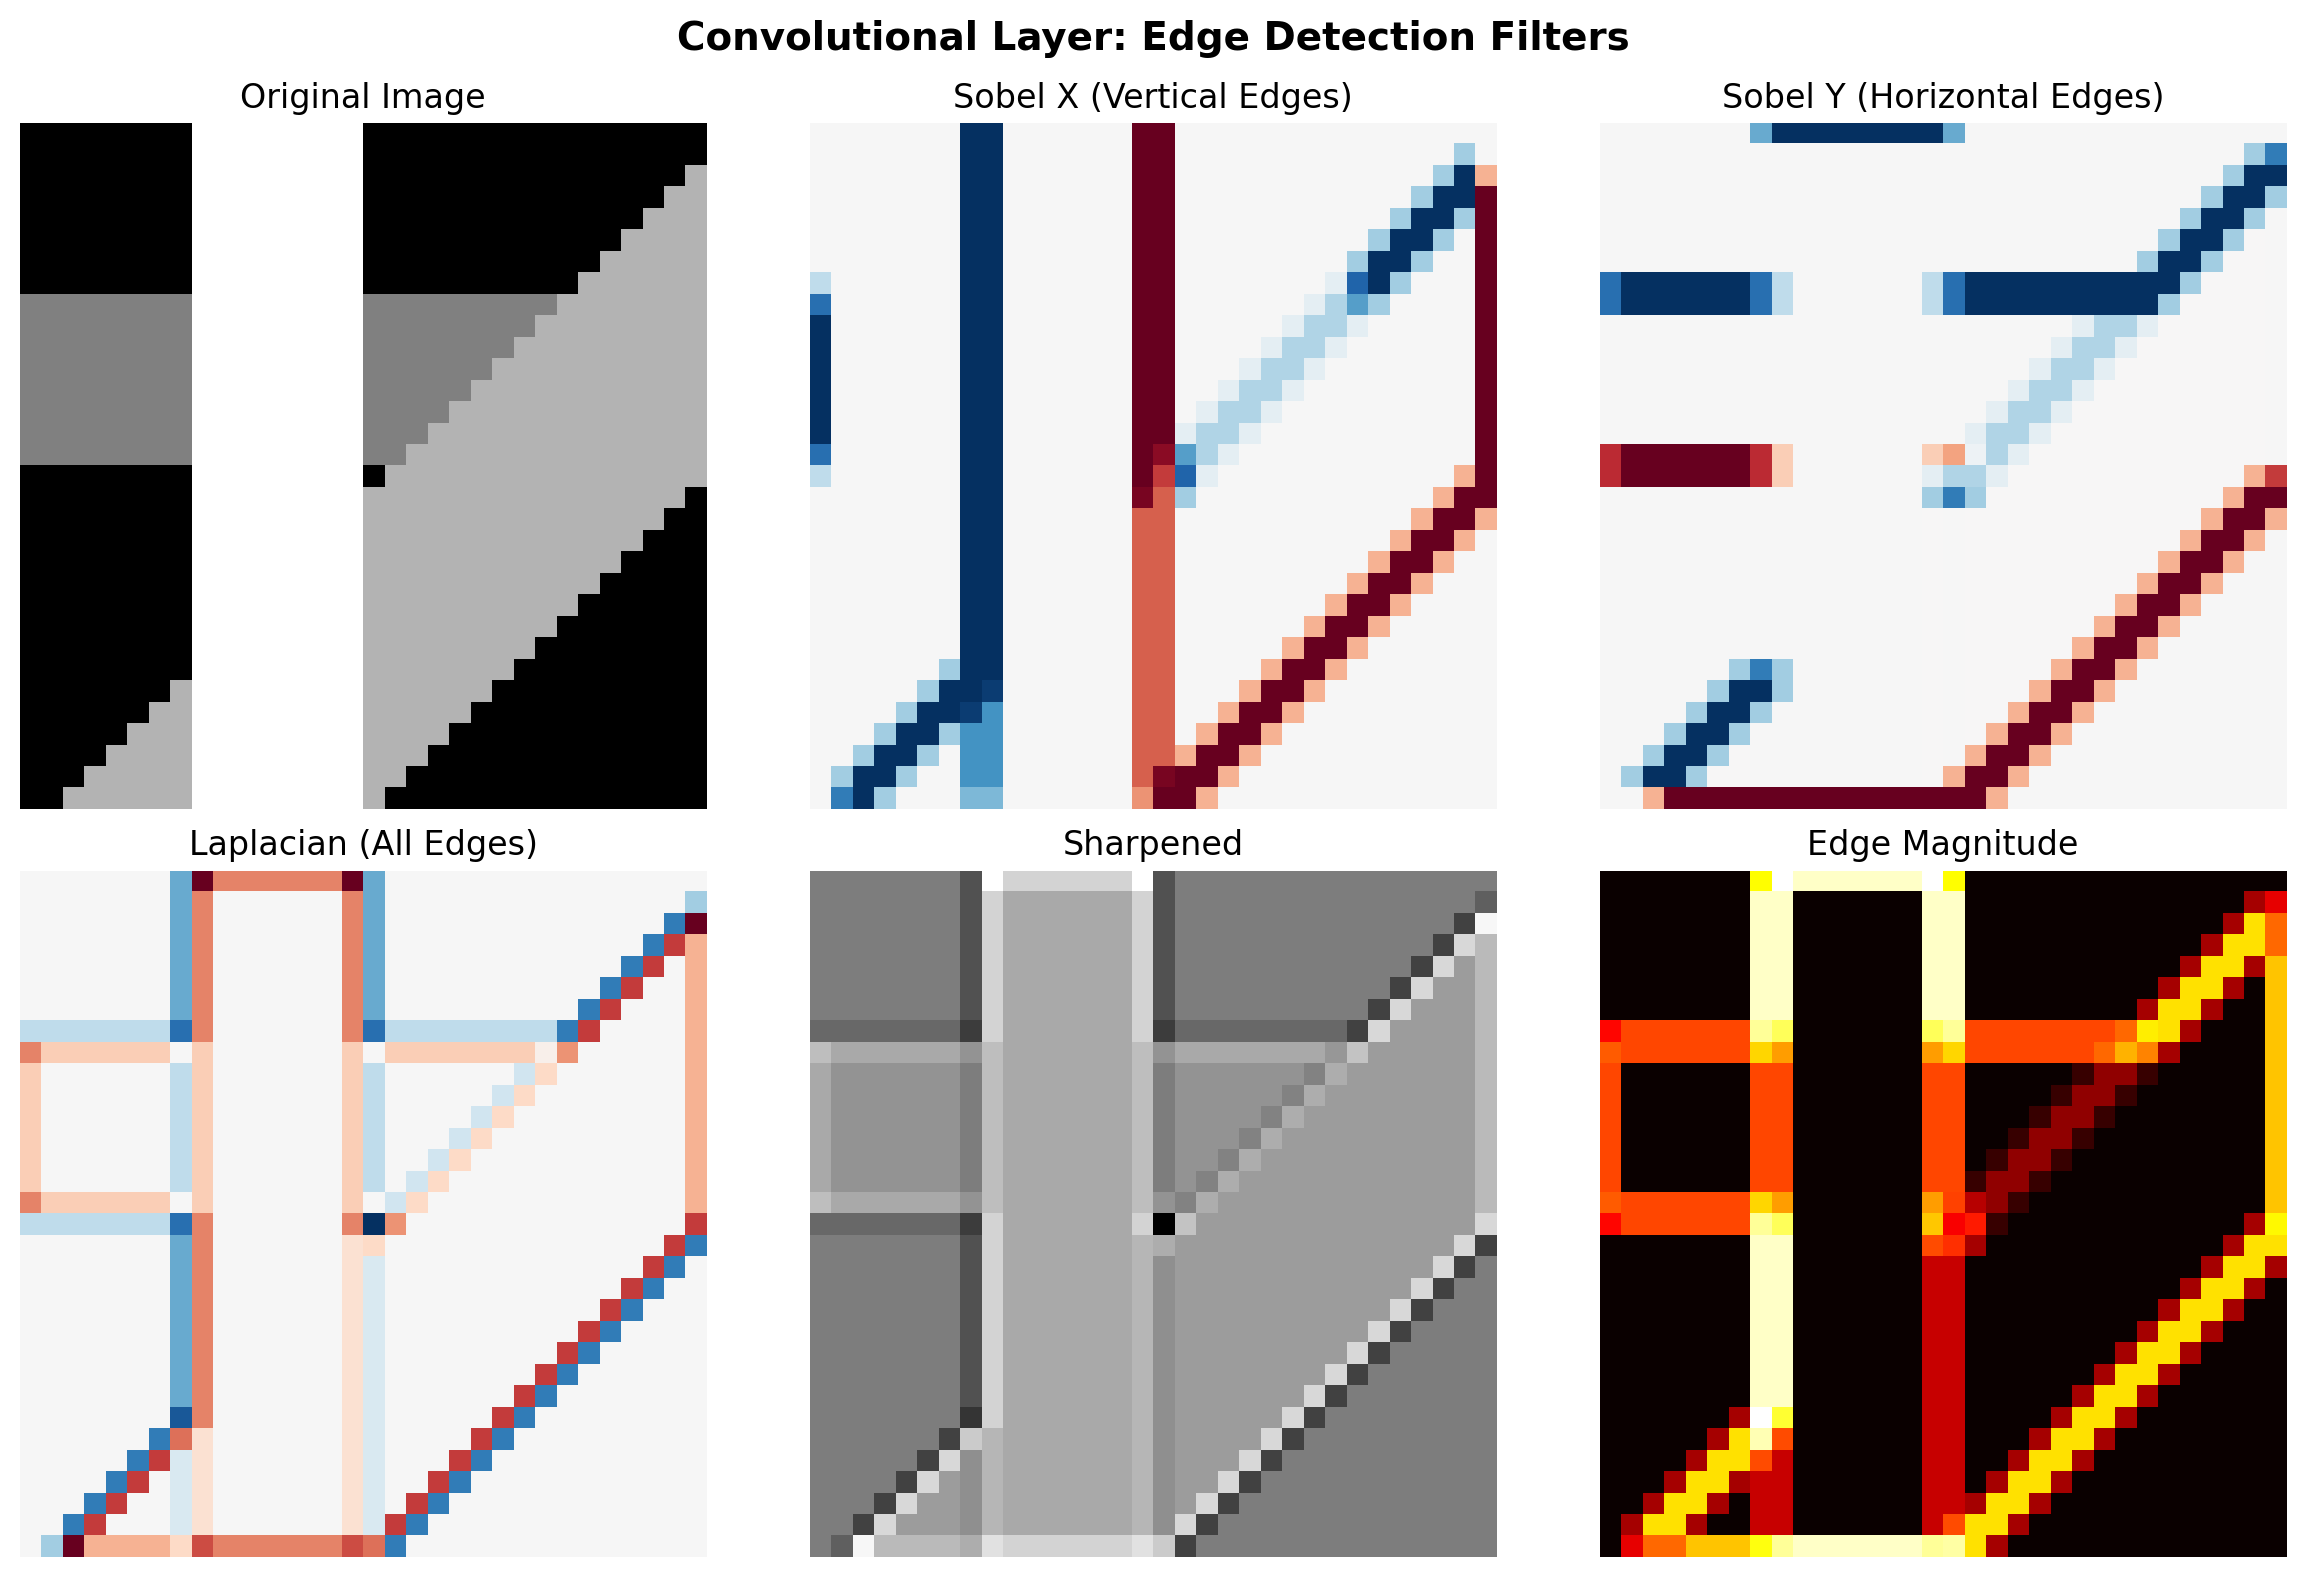

Plot saved to 'plot.png'


In [6]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Original image
axes[0, 0].imshow(test_img, cmap='gray')
axes[0, 0].set_title('Original Image', fontsize=12)
axes[0, 0].axis('off')

# Sobel X
axes[0, 1].imshow(output[0, 0], cmap='RdBu', vmin=-2, vmax=2)
axes[0, 1].set_title('Sobel X (Vertical Edges)', fontsize=12)
axes[0, 1].axis('off')

# Sobel Y
axes[0, 2].imshow(output[0, 1], cmap='RdBu', vmin=-2, vmax=2)
axes[0, 2].set_title('Sobel Y (Horizontal Edges)', fontsize=12)
axes[0, 2].axis('off')

# Laplacian
axes[1, 0].imshow(output[0, 2], cmap='RdBu', vmin=-2, vmax=2)
axes[1, 0].set_title('Laplacian (All Edges)', fontsize=12)
axes[1, 0].axis('off')

# Sharpen
axes[1, 1].imshow(output[0, 3], cmap='gray')
axes[1, 1].set_title('Sharpened', fontsize=12)
axes[1, 1].axis('off')

# Edge magnitude (Sobel)
edge_magnitude = np.sqrt(output[0, 0]**2 + output[0, 1]**2)
axes[1, 2].imshow(edge_magnitude, cmap='hot')
axes[1, 2].set_title('Edge Magnitude', fontsize=12)
axes[1, 2].axis('off')

plt.suptitle('Convolutional Layer: Edge Detection Filters', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('convolutional_layer_implementation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Plot saved to 'plot.png'")

## 5. Gradient Check

Verify the backward pass implementation using numerical gradient checking.

In [7]:
def numerical_gradient(f, x, eps=1e-5):
    """Compute numerical gradient using central differences."""
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'])
    
    while not it.finished:
        idx = it.multi_index
        old_val = x[idx]
        
        x[idx] = old_val + eps
        fx_plus = f(x)
        
        x[idx] = old_val - eps
        fx_minus = f(x)
        
        grad[idx] = (fx_plus - fx_minus) / (2 * eps)
        x[idx] = old_val
        
        it.iternext()
    
    return grad

# Create small test case
np.random.seed(123)
x_test = np.random.randn(2, 3, 8, 8)
y_target = np.random.randn(2, 4, 6, 6)

# Create layer
conv_test = Conv2D(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=0)

# Forward and backward
output_test = conv_test.forward(x_test)
loss = mse_loss(output_test, y_target)
grad_output = mse_loss_backward(output_test, y_target)
grad_input = conv_test.backward(grad_output)

# Numerical gradient check for weights
def loss_fn_weights(w):
    conv_test.weights = w.reshape(conv_test.weights.shape)
    out = conv_test.forward(x_test)
    return mse_loss(out, y_target)

num_grad_weights = numerical_gradient(loss_fn_weights, conv_test.weights.flatten())
num_grad_weights = num_grad_weights.reshape(conv_test.weights.shape)

# Recompute analytical gradient
output_test = conv_test.forward(x_test)
grad_output = mse_loss_backward(output_test, y_target)
conv_test.backward(grad_output)

# Compare gradients
diff = np.abs(num_grad_weights - conv_test.grad_weights)
rel_error = np.max(diff / (np.maximum(np.abs(num_grad_weights) + np.abs(conv_test.grad_weights), 1e-8)))

print(f"Gradient Check Results:")
print(f"  Max absolute difference: {np.max(diff):.2e}")
print(f"  Relative error: {rel_error:.2e}")
print(f"  Status: {'PASSED' if rel_error < 1e-5 else 'FAILED'}")

Gradient Check Results:
  Max absolute difference: 4.08e-11
  Relative error: 3.12e-09
  Status: PASSED


## 6. Learning Example: Simple Pattern Detection

Train a convolutional layer to detect a specific pattern.

In [8]:
# Generate training data
def generate_training_data(n_samples=100, size=16):
    """Generate images with vertical or horizontal lines."""
    X = []
    Y = []  # 1 for vertical, 0 for horizontal
    
    for _ in range(n_samples):
        img = np.random.randn(size, size) * 0.1  # Noise
        
        if np.random.rand() > 0.5:
            # Vertical line
            col = np.random.randint(2, size - 2)
            img[:, col-1:col+2] += 1.0
            Y.append(1)
        else:
            # Horizontal line
            row = np.random.randint(2, size - 2)
            img[row-1:row+2, :] += 1.0
            Y.append(0)
        
        X.append(img)
    
    X = np.array(X).reshape(n_samples, 1, size, size)
    Y = np.array(Y).reshape(n_samples, 1)
    
    return X, Y

# Generate data
X_train, Y_train = generate_training_data(200, 16)
print(f"Training data shape: {X_train.shape}")
print(f"Labels shape: {Y_train.shape}")

Training data shape: (200, 1, 16, 16)
Labels shape: (200, 1)


In [9]:
# Simple training loop
conv_learn = Conv2D(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=0)
learning_rate = 0.01
n_epochs = 50
batch_size = 32

losses = []

for epoch in range(n_epochs):
    epoch_loss = 0
    
    # Shuffle data
    indices = np.random.permutation(len(X_train))
    
    for i in range(0, len(X_train), batch_size):
        batch_idx = indices[i:i+batch_size]
        x_batch = X_train[batch_idx]
        y_batch = Y_train[batch_idx]
        
        # Forward pass
        out = conv_learn.forward(x_batch)
        
        # Global average pooling
        pooled = np.mean(out, axis=(2, 3))  # (batch, 2)
        
        # Simple prediction: difference between two channel means
        pred = (pooled[:, 0:1] - pooled[:, 1:2] + 1) / 2  # Normalize to [0, 1]
        
        # MSE loss
        loss = mse_loss(pred, y_batch)
        epoch_loss += loss
        
        # Backward pass
        grad_pred = mse_loss_backward(pred, y_batch)
        
        # Gradient through pooling
        grad_pooled = np.zeros_like(pooled)
        grad_pooled[:, 0:1] = grad_pred / 2
        grad_pooled[:, 1:2] = -grad_pred / 2
        
        # Gradient through average pooling
        grad_out = grad_pooled[:, :, np.newaxis, np.newaxis] / (out.shape[2] * out.shape[3])
        grad_out = np.broadcast_to(grad_out, out.shape).copy()
        
        # Backward through conv
        conv_learn.backward(grad_out)
        
        # Update weights
        conv_learn.weights -= learning_rate * conv_learn.grad_weights
        conv_learn.bias -= learning_rate * conv_learn.grad_bias
    
    losses.append(epoch_loss / (len(X_train) // batch_size))
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {losses[-1]:.4f}")

Epoch 10/50, Loss: 0.2910


Epoch 20/50, Loss: 0.2897


Epoch 30/50, Loss: 0.2909


Epoch 40/50, Loss: 0.2895


Epoch 50/50, Loss: 0.2893


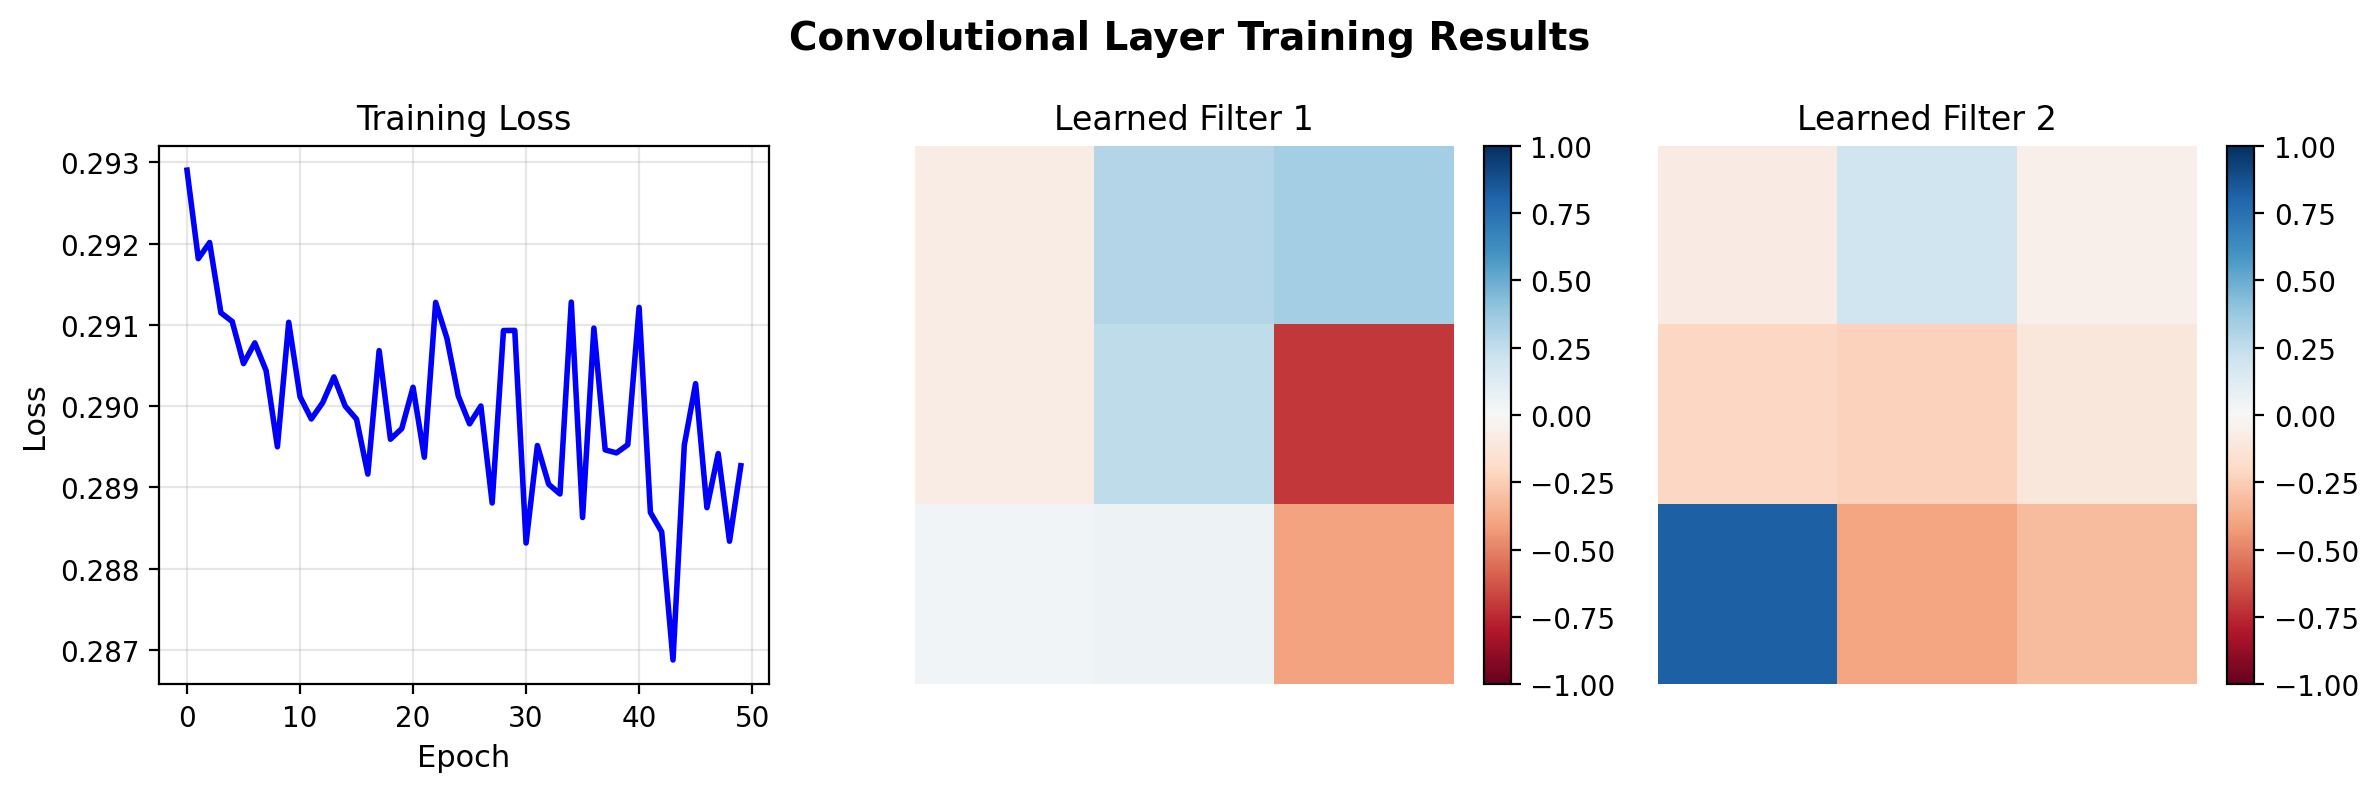

Final plot saved to 'plot.png'


In [10]:
# Visualize learned filters and training progress
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Training loss
axes[0].plot(losses, 'b-', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss', fontsize=11)
axes[0].set_title('Training Loss', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Learned filter 1
im1 = axes[1].imshow(conv_learn.weights[0, 0], cmap='RdBu', vmin=-1, vmax=1)
axes[1].set_title('Learned Filter 1', fontsize=12)
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# Learned filter 2
im2 = axes[2].imshow(conv_learn.weights[1, 0], cmap='RdBu', vmin=-1, vmax=1)
axes[2].set_title('Learned Filter 2', fontsize=12)
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046)

plt.suptitle('Convolutional Layer Training Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('convolutional_layer_implementation_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("Final plot saved to 'plot.png'")

## 7. Summary

This notebook demonstrated:

1. **Mathematical foundations** of 2D convolution operations in deep learning
2. **Complete implementation** of a convolutional layer with forward and backward passes
3. **Edge detection** using classical kernels (Sobel, Laplacian)
4. **Gradient verification** using numerical differentiation
5. **Learning from data** - training the layer to detect patterns

### Key Takeaways

- Convolutional layers learn spatially-invariant features through shared weights
- The backward pass involves computing gradients w.r.t. both weights and inputs
- Padding preserves spatial dimensions; stride controls downsampling
- Xavier initialization helps with gradient flow in deep networks

### References

1. LeCun, Y., et al. (1998). Gradient-based learning applied to document recognition. *Proceedings of the IEEE*.
2. Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning*. MIT Press.
3. He, K., et al. (2015). Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification. *ICCV*.